In [1]:
from pathlib import Path
import shutil
import torch
import PIL
import numpy as np

HF_REPO_ID = "williamberman/vq-diffusion-orig"
G_DRIVE_MOUNT_PATH = "/content/drive"
ITHQ_VQVAE_WEIGHTS_FILENAME = "ithq_vqvae.pth"
ITHQ_WEIGHTS_FILENAME = "ithq_learnable.pth"
CLIP_WEIGHTS_FILENAME = "ViT-B-32.pt"

G_DRIVE_PATH = Path(G_DRIVE_MOUNT_PATH) / "MyDrive"

G_DRIVE_ITHQ_WEIGHTS_PATH = G_DRIVE_PATH / ITHQ_WEIGHTS_FILENAME
G_DRIVE_ITHQ_VQVAE_WEIGHTS_PATH = G_DRIVE_PATH / ITHQ_VQVAE_WEIGHTS_FILENAME
G_DRIVE_CLIP_WEIGHTS_PATH = G_DRIVE_PATH / CLIP_WEIGHTS_FILENAME

# Final locations of the original checkpoint files. Will either be symlinks from
# huggingface cache or from google drive.
ITHQ_WEIGHTS_PATH = Path("/content") / ITHQ_WEIGHTS_FILENAME
ITHQ_VQVAE_WEIGHTS_PATH = Path("/content") / ITHQ_VQVAE_WEIGHTS_FILENAME
CLIP_WEIGHTS_PATH = Path("/content") / CLIP_WEIGHTS_FILENAME

CONVERTED_DIFFUSERS_MODEL_PATH = Path("/content/vq-diffusion-diffusers-dump")

In [ ]:
# Download model weights.

# Skip this step if you already have weights downloaded and saved to your google drive

! pip install huggingface_hub

from huggingface_hub import hf_hub_download, scan_cache_dir

hf_hub_download(
    repo_id=HF_REPO_ID,
    filename=ITHQ_VQVAE_WEIGHTS_FILENAME, 
)

hf_hub_download(
    repo_id=HF_REPO_ID,
    filename=ITHQ_WEIGHTS_FILENAME, 
)

hf_hub_download(
    repo_id=HF_REPO_ID,
    filename=CLIP_WEIGHTS_FILENAME, 
)

found_revision = None

for repo in scan_cache_dir().repos:
  if repo.repo_id == HF_REPO_ID:
    found_revision = next(iter(repo.revisions))

assert found_revision is not None, f"could not find repo {HF_REPO_ID}. Did you download it?"

found_vqvae_weights_file = None
found_weights_file = None
found_clip_weights_file = None

for file in found_revision.files:
  if file.file_name == ITHQ_VQVAE_WEIGHTS_FILENAME:
    found_vqvae_weights_file = file.file_path

  if file.file_name == ITHQ_WEIGHTS_FILENAME:
    found_weights_file = file.file_path

  if file.file_name == CLIP_WEIGHTS_FILENAME:
    found_clip_weights_file = file.file_path

assert found_vqvae_weights_file and found_weights_file and found_clip_weights_file, f"found not find {ITHQ_VQVAE_WEIGHTS_FILENAME}, {ITHQ_WEIGHTS_FILENAME}, and {CLIP_WEIGHTS_FILENAME}"

ITHQ_VQVAE_WEIGHTS_PATH.symlink_to(found_vqvae_weights_file)
ITHQ_WEIGHTS_PATH.symlink_to(found_weights_file)
CLIP_WEIGHTS_PATH.symlink_to(found_clip_weights_file)

In [ ]:
# Move model weights to your google drive. 
#
# Skip this step if you already have weights downloaded and saved to your google drive.
#
# Skip this step if you don't want to mount your google drive and want to use local weights. 
# Note there is no way to mount an isolated subdirectory of your google drive and this 
# _will_ give this notebook full access to your google drive.

from google.colab import drive

drive.mount(G_DRIVE_MOUNT_PATH)

print("copying vqvae weights")

shutil.copy(str(found_vqvae_weights_file), str(G_DRIVE_ITHQ_VQVAE_WEIGHTS_PATH))

print("done copying vqvae weights")

print("copying model weights")

shutil.copy(str(found_weights_file), str(G_DRIVE_ITHQ_WEIGHTS_PATH))

print("done copying model weights")

print("copying clip weights")

shutil.copy(str(found_clip_weights_file), str(G_DRIVE_CLIP_WEIGHTS_PATH))

print("done copying clip weights")

In [ ]:
# Mount google drive, and symlink weights into expected location
#
# Run this step if you already have weights downloaded and saved to your google drive
#
# Skip this step if you don't want to mount your google drive and want to use local weights. 
# Note there is no way to mount an isolated subdirectory of your google drive and this 
# _will_ give this notebook full access to your google drive.

from google.colab import drive

drive.mount(G_DRIVE_MOUNT_PATH)

ITHQ_VQVAE_WEIGHTS_PATH.symlink_to(G_DRIVE_ITHQ_VQVAE_WEIGHTS_PATH)
ITHQ_WEIGHTS_PATH.symlink_to(G_DRIVE_ITHQ_WEIGHTS_PATH)
CLIP_WEIGHTS_PATH.symlink_to(G_DRIVE_CLIP_WEIGHTS_PATH)

In [ ]:
# clone diffusers, original VQ-Diffusion implementation, and notebook dependencies
! git clone https://github.com/williamberman/diffusers.git && cd diffusers && git checkout vq-diffusion-ithq-vqvae
! git clone https://github.com/williamberman/VQ-Diffusion.git && cd VQ-Diffusion && git checkout will/changes-for-testing
! git clone https://github.com/williamberman/vq-diffusion-notebook.git

# A cat image for the autoencoder
! wget https://news.artnet.com/app/news-upload/2019/01/Cat-Photog-Feat-256x256.jpg -O /content/cat.jpg

# symlink weights into original VQ-Diffusion
Path("/content/VQ-Diffusion/OUTPUT/pretrained_model/taming_dvae/ithq_vqvae.pth").symlink_to(ITHQ_VQVAE_WEIGHTS_PATH)
Path("/content/VQ-Diffusion/OUTPUT/pretrained_model/ithq_learnable.pth").symlink_to(ITHQ_WEIGHTS_PATH)
Path("/content/VQ-Diffusion/OUTPUT/pretrained_model/ViT-B-32.pt").symlink_to(CLIP_WEIGHTS_PATH)

# copy testing script into original VQ-Diffusion - can't be symlinked because
# breaks python imports
shutil.copy("/content/vq-diffusion-notebook/test_vq_diffusion_orig.py", "/content/VQ-Diffusion/test_vq_diffusion_orig.py")

In [ ]:
# Install python dependencies.

! wget https://repo.anaconda.com/miniconda/Miniconda3-py39_4.12.0-Linux-x86_64.sh 
! bash Miniconda3-py39_4.12.0-Linux-x86_64.sh -b -f -p /usr/local
! conda init bash

# Create a conda env named hf for huggingface dependencies.
! conda create -n hf python=3.9 -y

# Create a conda env named vq-diffusion for original vq-diffusion
! conda create -n vq-diffusion python=3.9 -y

# install original vq-diffusion dependencies
# Documented here + a few other undocumented ones
# https://github.com/microsoft/VQ-Diffusion/blob/3c98e77f721db7c787b76304fa2c96a36c7b00af/install_req.sh
! . "/usr/local/etc/profile.d/conda.sh" && conda activate vq-diffusion && \
    pip install torch==1.9.0 \
      torchvision \
      omegaconf \
      pytorch-lightning \
      timm==0.3.4 \
      tensorboard==1.15.0 \
      lmdb \
      tqdm \
      einops \
      ftfy \
      git+https://github.com/openai/DALL-E.git \
      opencv-python \
      regex

# install huggingface dependencies
! . "/usr/local/etc/profile.d/conda.sh" && conda activate hf && \
        cd diffusers && \
        pip install -e ".[dev]" && \
        pip install OmegaConf

In [ ]:
# convert original vq-diffusion to diffusers

print("converting vq diffusion to diffusers")

! . "/usr/local/etc/profile.d/conda.sh" && conda activate hf && \
        cd diffusers && \
        python ./scripts/convert_vq_diffusion_to_diffusers.py \
          --checkpoint_path /content/ithq_learnable.pth \
          --original_config_file /content/vq-diffusion-notebook/ithq.yaml \
          --vqvae_checkpoint_path /content/ithq_vqvae.pth \
          --vqvae_original_config_file /content/vq-diffusion-notebook/ithq_vqvae.yaml \
          --dump_path /content/vq-diffusion-diffusers-dump

print("done converting vq diffusion to diffusers")
print(f"converted model stored: {CONVERTED_DIFFUSERS_MODEL_PATH}")

In [ ]:
! . "/usr/local/etc/profile.d/conda.sh" && conda activate vq-diffusion && \
      cd VQ-Diffusion && \
      python test_vq_diffusion_orig.py

In [ ]:
! . "/usr/local/etc/profile.d/conda.sh" && conda activate hf && \
      python vq-diffusion-notebook/test_vq_diffusion_diffusers.py

In [8]:
# verify autoencoder

autoencoder_encoded = torch.load("/content/autoencoder_encoded_out.pt")
autoencoder_encoded_orig = torch.load("/content/autoencoder_encoded_out_orig.pt")

autoencoder_reconstructed = torch.load("/content/autoencoder_out.pt")
autoencoder_reconstructed_orig = torch.load("/content/autoencoder_out_orig.pt")

# embedding indices are ints, can directly compare
assert (autoencoder_encoded == autoencoder_encoded_orig).all()

diff = autoencoder_reconstructed - autoencoder_reconstructed_orig
mask = diff != 0

num_different = np.count_nonzero(diff)
# larger signed ints to not overflow when subtracting
diff_in_locations_where_diffs = autoencoder_reconstructed[mask].astype('int32') - autoencoder_reconstructed_orig[mask].astype('int32')
max_diff = np.max(np.abs(diff_in_locations_where_diffs))

print(f"Autoencoder reconstruction number pixels w/in channel different: {num_different}")
print(f"Autoencoder reconstruction pixels differ w/in channel by at max: {max_diff}")

Autoencoder reconstruction number pixels w/in channel different: 5
Autoencoder reconstruction pixels differ w/in channel by at max: 1


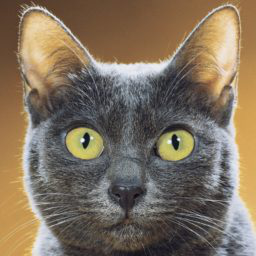

In [9]:
# original cat

PIL.Image.open("/content/cat.jpg")

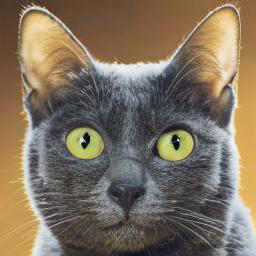

In [10]:
# reconstructed cat

PIL.Image.open("/content/cat-reconstructed.jpg")

In [11]:
# verify transformer

transformer_out = torch.load("/content/transformer_out.pt")
transformer_out_orig = torch.load("/content/transformer_out_orig.pt")

# convert from logspace into probabilities
transformer_out = transformer_out.exp()
transformer_out_orig = transformer_out_orig.exp()

max_transformer_diff = (transformer_out - transformer_out_orig).abs().max()
average_transformer_diff = (transformer_out - transformer_out_orig).abs().flatten().mean()

print("As probabilities:")
print(f"Max transformer difference {max_transformer_diff}")
print(f"Average transformer difference {average_transformer_diff}")

As probabilities:
Max transformer difference 9.778887033462524e-09
Average transformer difference 1.3827934630672445e-10


In [12]:
# verify text embedder

text_embedder_tokenized = torch.load("/content/text_embedder_tokenized_out.pt")
text_embedder_tokenized_orig = torch.load("/content/text_embedder_tokenized_out_orig.pt")

text_embedder_out = torch.load("/content/text_embedder_out.pt")
text_embedder_out_orig = torch.load("/content/text_embedder_out_orig.pt")

# tokens are all ints. can directly check equality.
assert (text_embedder_tokenized == text_embedder_tokenized_orig).all()

max_text_embedder_diff = (text_embedder_out - text_embedder_out_orig).abs().max()
average_text_embedder_diff = (text_embedder_out - text_embedder_out_orig).abs().flatten().mean()

print(f"Max text embedder difference {max_text_embedder_diff}")
print(f"Average text embedder difference {average_text_embedder_diff}")

Max text embedder difference 0.014677077531814575
Average text embedder difference 0.0009320175158791244


In [13]:
# verify e2e latent pixels

for t in range(99, -1, -1):
  latents_orig = torch.load(f"/content/e2e_latents_out_orig/{t}.pt")
  latents_diffusers = torch.load(f"/content/e2e_latents_out/{t}.pt")
  num_diff = (latents_orig != latents_diffusers).count_nonzero()

  if num_diff != 0:
    print(f"Diffusion step {t} differs at {num_diff} latent pixels")

Diffusion step 60 differs at 1 latent pixels
Diffusion step 59 differs at 2 latent pixels
Diffusion step 58 differs at 3 latent pixels
Diffusion step 57 differs at 5 latent pixels
Diffusion step 56 differs at 5 latent pixels
Diffusion step 55 differs at 5 latent pixels
Diffusion step 54 differs at 6 latent pixels
Diffusion step 53 differs at 8 latent pixels
Diffusion step 52 differs at 8 latent pixels
Diffusion step 51 differs at 8 latent pixels
Diffusion step 50 differs at 9 latent pixels
Diffusion step 49 differs at 9 latent pixels
Diffusion step 48 differs at 11 latent pixels
Diffusion step 47 differs at 12 latent pixels
Diffusion step 46 differs at 14 latent pixels
Diffusion step 45 differs at 16 latent pixels
Diffusion step 44 differs at 19 latent pixels
Diffusion step 43 differs at 22 latent pixels
Diffusion step 42 differs at 24 latent pixels
Diffusion step 41 differs at 26 latent pixels
Diffusion step 40 differs at 29 latent pixels
Diffusion step 39 differs at 30 latent pixels


In [14]:
# verify e2e output

orig_image = torch.load("/content/e2e_out_orig.pt")
diffusers_image = torch.load("/content/e2e_out.pt")

diff = diffusers_image - autoencoder_reconstructed_orig
mask = diff != 0

num_different = np.count_nonzero(diff)
# larger signed ints to not overflow when subtracting
diff_in_locations_where_diffs = orig_image[mask].astype('int32') - diffusers_image[mask].astype('int32')
max_diff = np.max(np.abs(diff_in_locations_where_diffs))

print(f"Generated image number pixels w/in channel different: {num_different}")
print(f"Generated pixels differ w/in channel by at max: {max_diff}")

Generated image number pixels w/in channel different: 195545
Generated pixels differ w/in channel by at max: 198


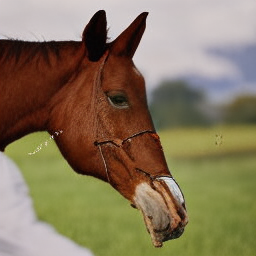

In [15]:
# original image

PIL.Image.open("/content/e2e_out_orig.png")

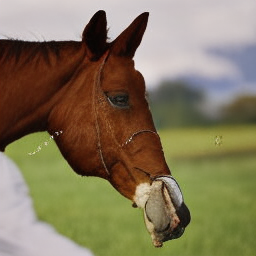

In [16]:
# diffusers image

PIL.Image.open("/content/e2e_out.png")